In [85]:
!nvidia-smi

Tue Oct  5 03:37:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    76W / 149W |   1281MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Setting up**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Basic_DeepLearning/Final_Project

/content/drive/MyDrive/Basic_DeepLearning/Final_Project


In [81]:
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import itertools
import string
from nltk.corpus import stopwords
from keras.models import Sequential, load_model
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Embedding, Flatten, Conv1D, MaxPooling1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [4]:
#   Ignore warning
import warnings
warnings.filterwarnings("ignore")

In [5]:
plt.style.available
plt.style.use('seaborn-whitegrid')

In [6]:
#   Set style for seaborn
sns.set(style = 'whitegrid', palette = 'muted', font_scale = 1.2)

In [7]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# ***Loading and preprocessing data***

In [8]:
def clean_doc(text):
    tokens = text.split()
    #  Remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [c.translate(table) for c in tokens]
    #   Remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    #   Filter out stop words. A stop word is a commonly used word (such as “a”, “an”, “in”, ...)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if not word in stop_words]
    #   Turn lower words into upper
    tokens = [word.lower() for word in tokens]
    #   Filter out short tokens
    tokens = [word for word in tokens if len(word) > 2]
    tokens = ' '.join(tokens)
    return tokens

In [9]:
def process_doc(data):
    documents = []
    for sentence in data:
        #   Clean review
        tokens = clean_doc(sentence)
        #   Add to ducuments
        documents.append(tokens)
    return documents

###***Loading data***

In [10]:
df = pd.read_csv("review.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


###***Preprocessing data***

In [11]:
df['labels'] = df['sentiment'].map({'positive': 1, 'negative': 0})
new_df = df[['review','labels']]
new_df.head()

,review,labels
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [12]:
#   Generate data and labels from new_df
data = list(new_df["review"])
labels = list(new_df["labels"])

#   Create val_set (5000 for val)
X_data, X_val, Y_data, Y_val = train_test_split(data, labels, test_size = 0.1, random_state = 42)

#   Create train_set, test_set (40500 for train, 4500 for test)
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size = 0.1, random_state = 42)

In [16]:
#   Generate Train_Set
X_train = process_doc(X_train)
#   Save Train_Set
np.savez('Train_Set.npz', x = X_train, y = Y_train)

#   Generate Test_Set
X_test = process_doc(X_test)
#   Save Test_Set
np.savez('Test_Set.npz', x = X_test, y = Y_test)

#   Generate Val_Set
X_val = process_doc(X_val)
#   Save Val_Set
np.savez('Val_Set.npz', x = X_val, y = Y_val)

In [18]:
X_train[:5]

['watched movie first time around young kid scared jesus loved much dying get hands itbr remembered movie existed idea called went need know section imdb explained movie tried get name anyway eventually someone imdb told researched tried buy movie eventually got hold dvd keep movie one valuable horror movies really love think anyone watches scared woods next time',
 'movie probably overall meditative quality music beautiful photography listening often cliché things life andy goldsworthy would say worked shots youre familiar buddhism sort sense got film impermanence life beauty nature interconnectedness things etc however understand confused ultimately forced leave without finishing saw hour redundancy whole thing find bits pieces hes commissioned even afford live kind work art work comes alive talking conclusions leads dead ends',
 'classic american movie combination comedy romance dream may say lots kind films already believe youll find good one well directed scripted played amanda by

# ***I. CNN for Text Classification***

In [41]:
#   Load Train_Set
train_set = np.load('data/Train_Set.npz')
X_train = train_set['x']
Y_train = train_set['y']

In [42]:
#   Define Tokenizer
tok = Tokenizer(oov_token = '<OOV>')
tok.fit_on_texts(X_train)

In [43]:
tok.word_index

{'<OOV>': 1,
 'the': 2,
 'and': 3,
 'this': 4,
 'that': 5,
 'was': 6,
 'with': 7,
 'for': 8,
 'movie': 9,
 'but': 10,
 'film': 11,
 'not': 12,
 'you': 13,
 'are': 14,
 'his': 15,
 'have': 16,
 'one': 17,
 'its': 18,
 'all': 19,
 'they': 20,
 'from': 21,
 'who': 22,
 'like': 23,
 'just': 24,
 'her': 25,
 'about': 26,
 'has': 27,
 'out': 28,
 'some': 29,
 'there': 30,
 'what': 31,
 'good': 32,
 'when': 33,
 'very': 34,
 'more': 35,
 'even': 36,
 'would': 37,
 'she': 38,
 'time': 39,
 'only': 40,
 'really': 41,
 'which': 42,
 'their': 43,
 'see': 44,
 'story': 45,
 'were': 46,
 'had': 47,
 'can': 48,
 'than': 49,
 'much': 50,
 'well': 51,
 'been': 52,
 'get': 53,
 'will': 54,
 'also': 55,
 'great': 56,
 'into': 57,
 'other': 58,
 'bad': 59,
 'because': 60,
 'people': 61,
 'how': 62,
 'most': 63,
 'first': 64,
 'dont': 65,
 'him': 66,
 'then': 67,
 'movies': 68,
 'made': 69,
 'make': 70,
 'could': 71,
 'them': 72,
 'way': 73,
 'films': 74,
 'any': 75,
 'after': 76,
 'too': 77,
 'characters

In [44]:
#  Encode sequences
train_encoded = tok.texts_to_sequences(X_train)

#  Ensure that all reviews have the same lenght
max_len = 1000
train_padded = pad_sequences(train_encoded, maxlen = max_len, truncating = 'post', padding = 'post')
vocab_size = len(tok.word_index) + 1

In [45]:
print(train_padded)
print("\nShape:", train_padded.shape)

[[ 245    4    9 ...    0    0    0]
 [   4    9  206 ...    0    0    0]
 [   4  324  276 ...    0    0    0]
 ...
 [ 114   41   88 ...    0    0    0]
 [   4    9    6 ...    0    0    0]
 [   2  251 3567 ...    0    0    0]]

Shape: (40500, 1000)


###***Load Val_Set***

In [46]:
val_set = np.load('data/Val_Set.npz')
X_val = val_set['x']
Y_val = val_set['y']

#  Encode sequences
val_encoded = tok.texts_to_sequences(X_val)
val_padded = pad_sequences(val_encoded, maxlen = max_len, truncating = 'post', padding = 'post')

#### *Convolutional Neural Network to define model (Conv1D layer)*
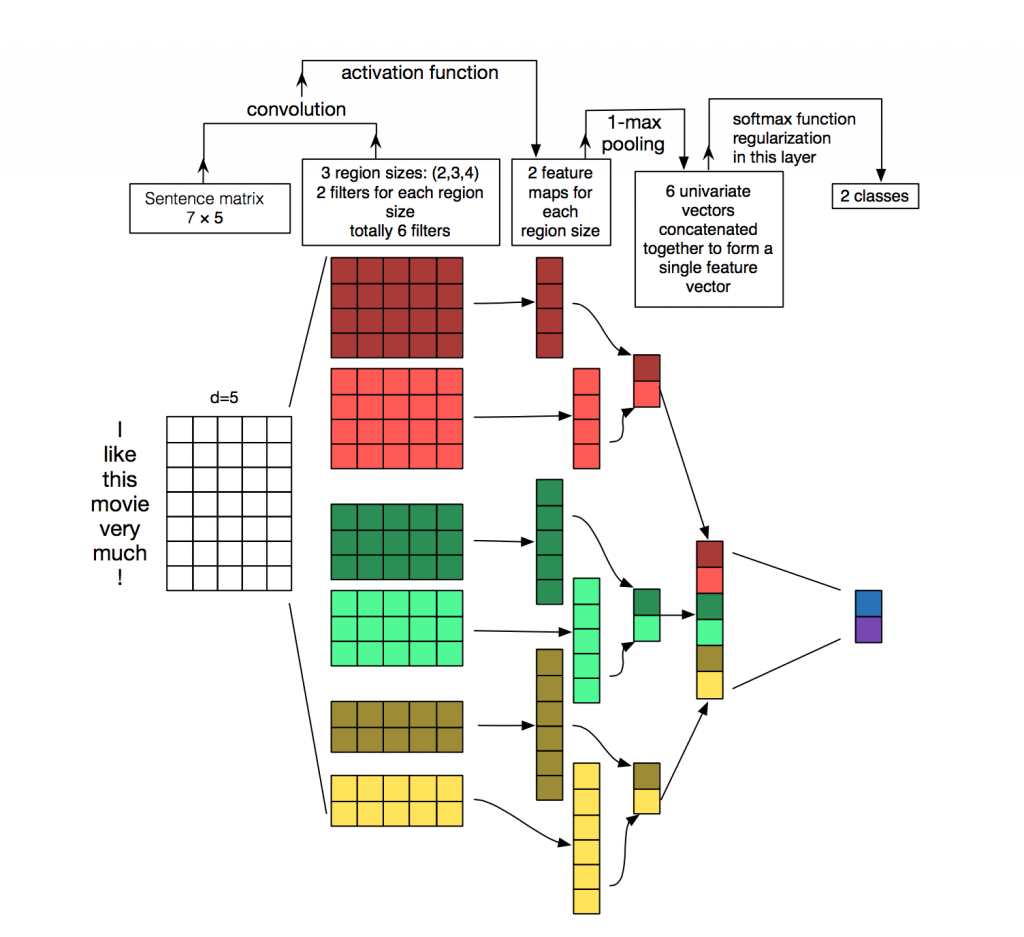

$=>$ We use Convolutional Model to learn extract salients features from documents

In [47]:
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length = max_len))
model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu', kernel_regularizer = l2(0.0001)))
model.add(MaxPooling1D(pool_size = 2))
model.add(Flatten())
model.add(Dense(32, activation = 'tanh'))
model.add(Dropout(0.4))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 128)         6922112   
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 128)          82048     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 498, 128)          0         
_________________________________________________________________
flatten (Flatten)            (None, 63744)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                2039840   
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [48]:
# Compiling
model.compile(optimizer = "RMSprop", loss = 'binary_crossentropy', metrics = ['acc'])

### ***Training***

In [ ]:
# Fit to network
H = model.fit(train_padded, Y_train, epochs = 3, batch_size = 64, validation_data = (val_padded, Y_val))

Epoch 1/3
633/633 [==============================] - 31s 47ms/step - loss: 0.4623 - acc: 0.7722 - val_loss: 0.2428 - val_acc: 0.9050
Epoch 2/3
633/633 [==============================] - 29s 46ms/step - loss: 0.1851 - acc: 0.9353 - val_loss: 0.2629 - val_acc: 0.9036
Epoch 3/3
633/633 [==============================] - 29s 45ms/step - loss: 0.1207 - acc: 0.9632 - val_loss: 0.2850 - val_acc: 0.9068


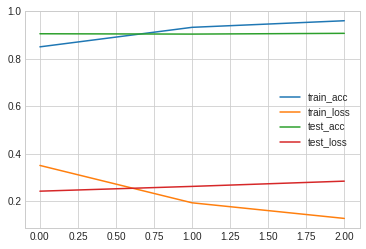

In [ ]:
plt.plot(H.history['acc'], label = 'train_acc')
plt.plot(H.history['loss'], label = 'train_loss')
plt.plot(H.history['val_acc'], label = 'test_acc')
plt.plot(H.history['val_loss'], label = 'test_loss')
plt.legend();

In [56]:
model.save("my_model/MODEL.h5")

### ***Evaluating***

In [57]:
#   Load model
model = load_model('my_model/MODEL.h5')

In [53]:
#   Load Test_Set
test_set = np.load('data/Test_Set.npz')
X_test = test_set['x']
Y_test = test_set['y']

#   Encode and padding the TestSet for evaluate procedure
test_encoded = tok.texts_to_sequences(X_test)
test_padded = pad_sequences(test_encoded, maxlen = max_len, padding = 'post')

In [58]:
pred = model.predict(test_padded)
print('Number of positive reviews are predicted:', np.sum(pred > 0.5))
print('Number of negative reviews are predicted:', np.sum(pred < 0.5))

Number of positive reviews are predicted: 2153
Number of negative reviews are predicted: 2347


In [ ]:
print("Number of real positive review:", np.sum(Y_test == 1))
print("Number of real negative review:", np.sum(Y_test == 0))

Number of real positive review: 2274
Number of real negative review: 2226


In [59]:
# Evaluation
score = model.evaluate(test_padded, Y_test, verbose = 0)
print(f'Test Accuracy: {round(score[1] * 100, 2)}%')
print(f'Test Loss: {round(score[0] * 100, 2)}%') 

Test Accuracy: 90.47%
Test Loss: 28.42%


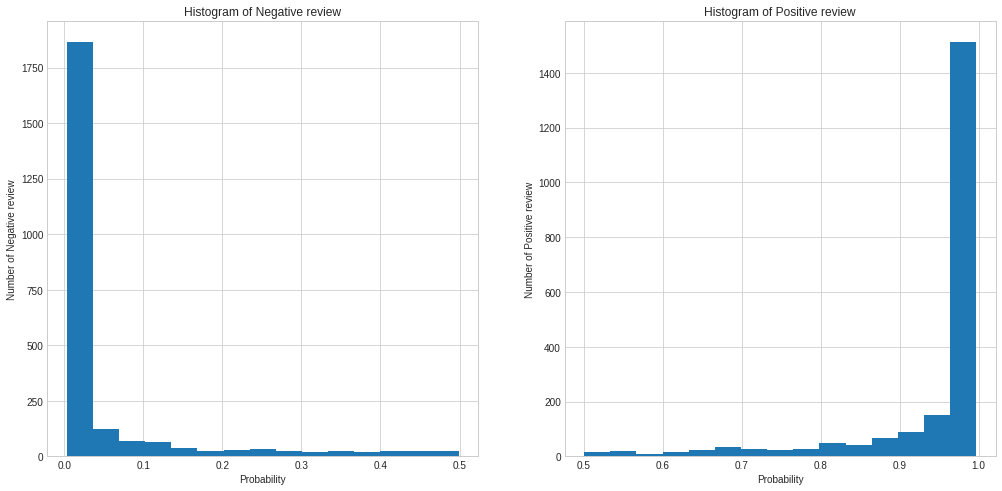

In [ ]:
#   Plot histogram 

pos_pred = []
neg_pred = []
for i in range(len(pred)):
  if pred[i][0] > 0.5:
    pos_pred.append(pred[i][0])
  else:
    neg_pred.append(pred[i][0])

plt.figure(figsize = (17, 8))
plt.subplot(1, 2, 1)
plt.hist(neg_pred, bins = 15)
plt.title('Histogram of Negative review')
plt.xlabel('Probability')
plt.ylabel('Number of Negative review')
plt.subplot(1, 2, 2)
plt.hist(pos_pred, bins = 15)
plt.title('Histogram of Positive review')
plt.xlabel('Probability')
plt.ylabel('Number of Positive review');

### ***Predicting on raw text***

In [61]:
review = ['This was an awesome movie. I watch it twice my time watching this beautiful movie if I have known it was this good',
          'One of the worst movies of all time. I cannot believe I wasted two hours of my life for this movie']          
encode = tok.texts_to_sequences(review)
padd = pad_sequences(encode, maxlen = max_len, truncating = 'post', padding = 'post')
pred = model.predict(padd)

In [76]:
pred

array([[0.9345969 ],
       [0.01385404]], dtype=float32)

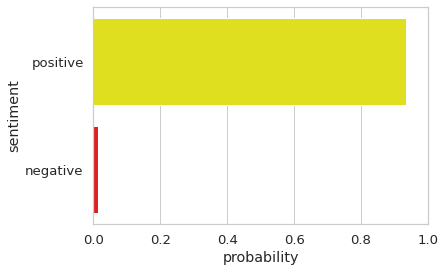

In [80]:
pred_df = pd.DataFrame({"class name": ['positive', 'negative'], "values": (pred[0, 0], pred[1, 0])})
#   Visualizing predicted result
colors = ['yellow', 'red']
sns.barplot(data = pred_df, x = 'values', y = 'class name', palette = colors)
plt.xlabel('probability')
plt.ylabel('sentiment')
plt.xlim([0, 1]);

# ***II. Pre-trained GloVe Embedding***

In [ ]:
#   Load pre-trained embedding vectors and add to dict()
word_embeds = dict()
f = open("glove.6B/glove.6B.100d.txt")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = "float32")
    word_embeds[word] = coefs
f.close()

In [ ]:
dict(itertools.islice(word_embeds.items(), 2))

{',': array([-0.10767  ,  0.11053  ,  0.59812  , -0.54361  ,  0.67396  ,
         0.10663  ,  0.038867 ,  0.35481  ,  0.06351  , -0.094189 ,
         0.15786  , -0.81665  ,  0.14172  ,  0.21939  ,  0.58505  ,
        -0.52158  ,  0.22783  , -0.16642  , -0.68228  ,  0.3587   ,
         0.42568  ,  0.19021  ,  0.91963  ,  0.57555  ,  0.46185  ,
         0.42363  , -0.095399 , -0.42749  , -0.16567  , -0.056842 ,
        -0.29595  ,  0.26037  , -0.26606  , -0.070404 , -0.27662  ,
         0.15821  ,  0.69825  ,  0.43081  ,  0.27952  , -0.45437  ,
        -0.33801  , -0.58184  ,  0.22364  , -0.5778   , -0.26862  ,
        -0.20425  ,  0.56394  , -0.58524  , -0.14365  , -0.64218  ,
         0.0054697, -0.35248  ,  0.16162  ,  1.1796   , -0.47674  ,
        -2.7553   , -0.1321   , -0.047729 ,  1.0655   ,  1.1034   ,
        -0.2208   ,  0.18669  ,  0.13177  ,  0.15117  ,  0.7131   ,
        -0.35215  ,  0.91348  ,  0.61783  ,  0.70992  ,  0.23955  ,
        -0.14571  , -0.37859  , -0.045959 ,

In [ ]:
#   Generate an array of embedding vectors
embeddings_mtr = np.zeros((vocab_size, 100))
word_vocab = []
for word, index in tok.word_index.items():
    embedding_vector = word_embeds.get(word)
    word_vocab.append(word)
    if embedding_vector is not None:
        embeddings_mtr[index] = embedding_vector

In [ ]:
#   We don't wanna update the learned word weights in this model, therefore, we set trainable = False
emb_layer = Embedding(input_dim = vocab_size, output_dim = 100, input_length = max_len, weights = [embeddings_mtr], trainable = False)

In [ ]:
model = Sequential()
model.add(emb_layer)
model.add(Flatten())
model.add(Dense(128, activation = 'tanh'))
model.add(Dropout(0.4))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         5407900   
_________________________________________________________________
flatten_7 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               12800128  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 18,208,157
Trainable params: 12,800,257
Non-trainable params: 5,407,900
_________________________________________________________________


In [ ]:
#   Compile model
model.compile(optimizer = "RMSprop", loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
model.fit(train_padded, Y_train, epochs = 10, batch_size = 64, validation_data = (val_padded, Y_val))

Epoch 1/10
633/633 [==============================] - 9s 13ms/step - loss: 0.8682 - acc: 0.5581 - val_loss: 0.5616 - val_acc: 0.7148
Epoch 2/10
633/633 [==============================] - 8s 13ms/step - loss: 0.5482 - acc: 0.7217 - val_loss: 0.5276 - val_acc: 0.7414
Epoch 3/10
633/633 [==============================] - 8s 13ms/step - loss: 0.4861 - acc: 0.7675 - val_loss: 0.5277 - val_acc: 0.7386
Epoch 4/10
633/633 [==============================] - 8s 13ms/step - loss: 0.4522 - acc: 0.7907 - val_loss: 0.5022 - val_acc: 0.7528
Epoch 5/10
633/633 [==============================] - 8s 13ms/step - loss: 0.4266 - acc: 0.8044 - val_loss: 0.5002 - val_acc: 0.7614
Epoch 6/10
633/633 [==============================] - 8s 13ms/step - loss: 0.3974 - acc: 0.8219 - val_loss: 0.5057 - val_acc: 0.7610
Epoch 7/10
633/633 [==============================] - 8s 13ms/step - loss: 0.3782 - acc: 0.8320 - val_loss: 0.5146 - val_acc: 0.7600
Epoch 8/10
633/633 [==============================] - 8s 13ms/step - 

Tuy nhiên, các mô hình kể trên có những yếu điểm riêng của nó, đặc biệt là không thể hiện được sự đại diện theo ngữ cảnh cụ thể của từ trong từng lĩnh vực hay văn cảnh cụ thể.

### $=>$  ***Visualization: Glove Embedding Vector with PCA***

In [ ]:
#   Create a 2-dimensional model of the word vectors using the sklearn PCA class
embed = embeddings_mtr[:150]
words = word_vocab[:150]
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
result = pca.fit_transform(embed)

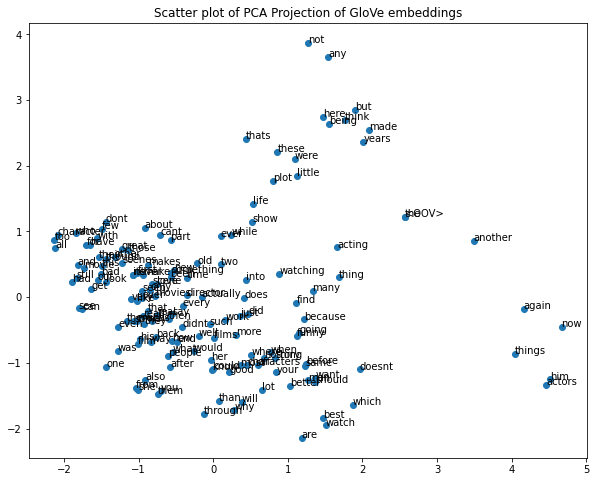

In [ ]:
# Create a scatter plot of the projection
plt.figure(figsize = (10, 8))
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
	plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.title("Scatter plot of PCA Projection of GloVe embeddings")
plt.show()

# ***III. BERT for Text Classification***

**BERT** stands for **B**idirectional **E**ncoder **R**epresentations from **T**ransformers. 
1. BERT is based on the Transformer architecture.
2. BERT is pre-trained on a large corpus of unlabelled tex
3. BERT is a “deeply bidirectional” model

***BERT*** has 2 tasks: Mask Language Modeling(*MLM*) and Next Sentence Prediction(*NSP*)

**1**. *Mask Language Modeling(MLM)*

That's [Mask] she [Mask]  $=>$ That's what she said

**2**. *Next Sentence Prediction*

- Input = [CLS] That's [Mask] she [Mask]. [SEP] Hahaha, nice! [SEP]

- Label = IsNext


- Input = [CLS] That's [Mask] she [Mask]. [SEP] Dwight, you ignorant [Mask]! [SEP]

- Label = NotNext


In [ ]:
!pip install transformers==3.0.0

In [ ]:
import transformers
import seaborn as sns
import re
import torch
from collections import defaultdict
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
df = pd.read_csv("review.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


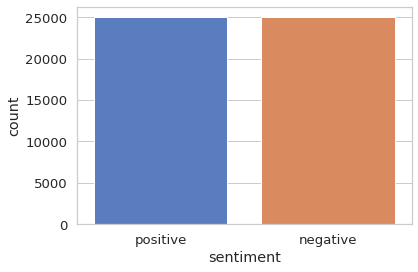

In [ ]:
#   Check wheather we have class imbalance
sns.countplot(df.sentiment)
plt.xlabel("sentiment");

$=>$ We don't have any imbalance which is perfect

Pre-processing

In [ ]:
#   Apply above function to every review in df
df['review_processed'] = df['review'].apply(clean_doc)

#   Also encode "sentiment" column: 1 for positive and 0 for negative
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

***Choosing Sequence Length***

In [ ]:
tokens_len = []
for index, value in df['review_processed'].items():
    tokens = tokenizer.encode(value, max_length = 800)
    tokens_len.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token Count')

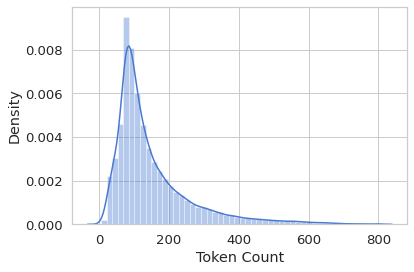

In [ ]:
sns.distplot(tokens_len);
plt.xlabel("Token Count")

$=>$ Most of the reviews have length about 100 tokens, but we'll be on the safe side and choose a maximum length of 512.

### Create Pytorch Dataset

In [ ]:
class IMDB_Dataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):  
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(review, max_length = self.max_len,
                                              add_special_tokens = True,      #  Add '[CLS]', '[PAD]' and '[SEP]'
                                              return_token_type_ids = False,  #  Return 0 for pre_sentence, 1 for post_sentence. Since our use case deals with only one sentence as opposed to use case which use 2 sentences in single training example(for ex: Question-anwering) we can have it as False
                                              truncation = True, padding = 'max_length',  # pad to longest sequence as defined by max_length
                                              return_attention_mask = True,   #  Return attention mask. Attention mask indicated to the model which tokens should be attended to, and which should not.
                                              return_tensors = 'pt')          #  Return PyTorch tensors
      
        return {'review_text': review,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype = torch.long)}

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(df[['review']], df['sentiment'], test_size = 0.3, random_state = 42)
df_train = pd.DataFrame({'review': X_train['review'].values, 'sentiment': Y_train.values})
df_val = pd.DataFrame({'review': X_val['review'].values, 'sentiment': Y_val.values})

X_val, X_test, Y_val, Y_test = train_test_split(df_val[['review']], df_val['sentiment'], test_size = 0.5, random_state = 42)
df_val = pd.DataFrame({'review': X_val['review'].values, 'sentiment': Y_val.values})
df_test = pd.DataFrame({'review': X_test['review'].values, 'sentiment': Y_test.values})

print(df_train.shape, df_val.shape, df_test.shape)

In [ ]:
#   Save DataFrame to file.csv
df_train.to_csv("df_train.csv", index = False)
df_test.to_csv("df_test.csv", index = False)
df_val.to_csv("df_val.csv", index = False)

### ***Create Data Generator***

In [ ]:
#   Read file.csv
df_train = pd.read_csv("df_data/df_train.csv")
df_test = pd.read_csv("df_data/df_test.csv")
df_val = pd.read_csv("df_data/df_val.csv")

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = IMDB_Dataset(reviews = df.review.to_numpy(),
                      targets = df.sentiment.to_numpy(),
                      tokenizer = tokenizer, max_len = max_len)
    return DataLoader(ds, batch_size = batch_size, num_workers = 4)

In [ ]:
#   Set batch_size
batch_size = 16
max_len = 512
train_data = create_data_loader(df_train, tokenizer, max_len, batch_size)
test_data = create_data_loader(df_test, tokenizer, max_len, batch_size)
val_data = create_data_loader(df_val, tokenizer, max_len, batch_size)

In [ ]:
#   Get a single batch from DataLoader without for__loop
data = next(iter(val_data))
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])


### Sentiment Classification with BERT and Hugging Face

In [ ]:
#   Mount GPU to Torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Check if Pytorch use GPU
torch.cuda.get_device_name()

'Tesla K80'

In [ ]:
#     Download BERT model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels = 2)
model = model.to(device)

###  Training

In [ ]:
#   Setting hyperparameter
epoches = 5

total_steps = len(train_data) * epoches

#   Optimizer function by using AdamW Pytorch
optimizer = AdamW(model.parameters(), lr = 5e-5)

#   Decreasing learning_rate over some epoches
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

### Define a function to train our model on one epoch

In [ ]:
#   Define function to train our model on one epoch
def train_epoch(model, data_loader, optimizer, device, scheduler, n_exams):

    model = model.train()    # Tells your model that we are training
    losses = []
    correct_predictions = 0

    #   Get a single batch in each loop
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        loss, logits = model(input_ids = input_ids, attention_mask = attention_mask, labels = targets)
        
        logits = logits.detach().cpu().numpy()
        label_ids = targets.cpu().numpy()

        preds = np.argmax(logits, axis=1).flatten()   #   Returns maximum index of logit
        targ = label_ids.flatten()

        correct_predictions += np.sum(preds == targ)

        losses.append(loss.item())
        loss.backward()     #       Performs backpropagation(computes derivates of loss to parameters)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #  Clipping gradients to avoid explode gradient
        optimizer.step()       #    After gradients are computed by loss.backward() this makes the optimizer iterate over all parameters it is supposed to update and use internally #stored grad to update their values
        scheduler.step()    #       Make sure learning rate changes. If we dont provide this param stays at initial value
        optimizer.zero_grad()   #   Clears old gradients from last step

    return correct_predictions/n_exams, np.mean(losses)

In [ ]:
#   Define function to validate our model on one epoch
def val_model(model, data_loader, device, n_exams):
    model = model.eval()    #   Tells model we are in validation mode
    losses = []
    correct_preds = 0

    with torch.no_grad():
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            targets = data['targets'].to(device)
            
            loss, logit = model(input_ids = input_ids, attention_mask = attention_mask, labels = targets)

            logits = logit.detach().cpu().numpy()
            labels = targets.cpu().numpy()

            preds = np.argmax(logits, axis = 1).flatten()
            targ = labels.flatten()

            correct_preds += np.sum(preds == targ)
            losses.append(loss.item())
    return correct_preds/n_exams, np.mean(losses)  

In [ ]:
history = defaultdict(list)
best_acc = 0

for epoch in range(epoches):

    print(f'Epoch {epoch + 1}/{epoches}[=============================]')

    train_acc, train_loss = train_epoch(model, train_data, optimizer, device, scheduler, len(df_train))
    print(f'Train: - Loss {train_loss}     - Accuracy {train_acc}')

    val_acc, val_loss = val_model(model, val_data, device, len(df_val))
    print(f'Val  : - Loss {val_loss}      - Accuracy {val_acc}\n')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_acc:
        torch.save(model.state_dict(), 'BERT_model.bin')
        best_acc = val_acc

Epoch 1/5[=============================]
Train: - Loss 0.2994514126926524     - Accuracy 0.8794571428571428
Val  : - Loss 0.23514060306348908      - Accuracy 0.9056

Epoch 2/5[=============================]
Train: - Loss 0.15870925487778695     - Accuracy 0.9504285714285714
Val  : - Loss 0.34006202575524275      - Accuracy 0.9121333333333334

Epoch 3/5[=============================]
Train: - Loss 0.08332648630801676     - Accuracy 0.9793142857142857
Val  : - Loss 0.4060766203597045      - Accuracy 0.9098666666666667

Epoch 4/5[=============================]
Train: - Loss 0.037765200742327996     - Accuracy 0.9916285714285714
Val  : - Loss 0.5345862069059717      - Accuracy 0.9106666666666666

Epoch 5/5[=============================]
Train: - Loss 0.018376840749794128     - Accuracy 0.9965142857142857
Val  : - Loss 0.5493092715091356      - Accuracy 0.9130666666666667



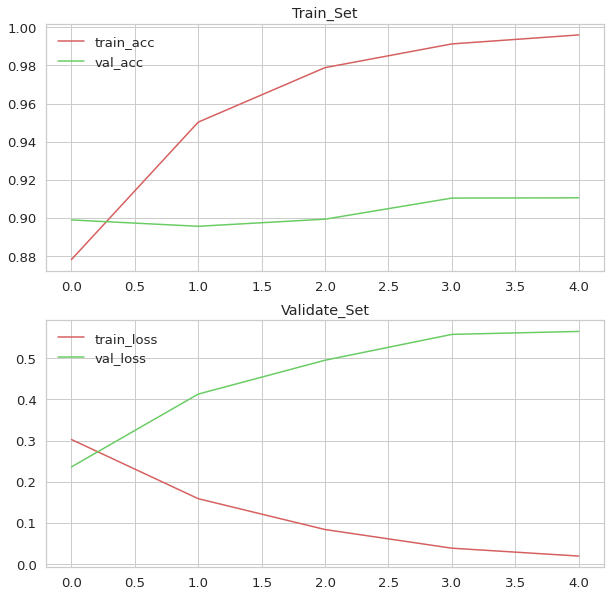

In [ ]:
plt.figure(figsize = (10, 10))
plt.subplot(2, 1, 1)
plt.plot(history['train_acc'], label = 'train_acc', color = 'r')
plt.plot(history['val_acc'], label = 'val_acc', color = 'g')
plt.title("Train_Set")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(history['train_loss'], label = 'train_loss', color = 'r')
plt.plot(history['val_loss'], label = 'val_loss', color = 'g')
plt.title("Validate_Set")
plt.legend();

### ***Evaluate model with TestSet***

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 2)
model.load_state_dict(torch.load('my_model/BERT_model_best.bin'))
#   Tells model to use CUDA device
model = model.to(device)

In [ ]:
test_acc, _ = val_model(model, test_data, device, len(df_test))
test_acc.item()

0.9150666666666667

$=>$ Our model seems to generalize very well

### ***Create Confusion Matrix to evaluate model***

1. *Create a function to get the predictions from model*

In [ ]:
def predict_model(model, data_loader, device):
    model = model.eval()  
    predicted = np.array([])
    real_val = np.array([])

    with torch.no_grad():  #  Tells model that don't use CUDA
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            targets = data['targets'].to(device)

            _, pred = model(input_ids = input_ids, attention_mask = attention_mask, labels = targets)

            #   Convert preds to numpy array
            preds = pred.detach().cpu().numpy()
            #  Get predict values by argmax
            pred_arg = np.argmax(preds, axis = 1).flatten()
            predicted = np.append(predicted, pred_arg)

            #   Convert targets values to numpy array
            targ = targets.cpu().numpy()
            labels = targ.flatten()
            real_val = np.append(real_val, labels)


    return real_val, predicted

2. *Create a confusion matrix function*

In [ ]:
def show_confusion_matrix(confus_mtr):
    hmap = sns.heatmap(confus_mtr, annot = True, fmt = "d", cmap = "Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 0, ha = 'right')
    plt.xlabel('Predicted sentiment')
    plt.ylabel('True sentiment');

3. *Get Evaluation*

In [ ]:
#   Get value from predict_model function
y_real, y_pred = predict_model(model, test_data, device)
print(y_real.shape)
print(y_pred.shape)

7500
7500


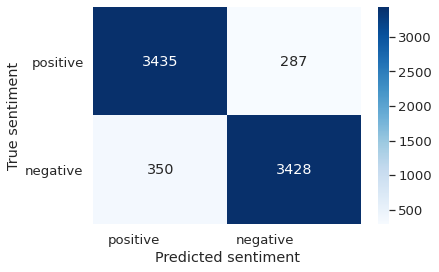

In [ ]:
#   Show Confusion Matrix
cm = confusion_matrix(y_real, y_pred)
class_names = ["positive", "negative"]
df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
show_confusion_matrix(df_cm)


In [ ]:
#   Count scale of false predicted review and the total
np.sum(y_real != y_pred) / len(df_test)

0.08493333333333333

$=>$ This confirms that our model is having difficult classifying neural reviews. It mistakes those for negative and positive at a roughly equal frequency. However, the scale of false predicted is quite small